In [32]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [33]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [34]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [35]:
# sub number
sub_num = 6

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 5s 48ms/step - loss: 0.5928 - accuracy: 0.7446 - val_loss: 0.5620 - val_accuracy: 0.7367
Epoch 2/200
99/99 [==============================] - ETA: 0s - loss: 0.5406 - accuracy: 0.7544
Epoch 00002: val_loss improved from inf to 0.55755, saving model to best_model_7.h5
99/99 [==============================] - 5s 46ms/step - loss: 0.5406 - accuracy: 0.7544 - val_loss: 0.5576 - val_accuracy: 0.7367
Epoch 3/200
99/99 [==============================] - ETA: 0s - loss: 0.5345 - accuracy: 0.7544
Epoch 00003: val_loss did not improve from 0.55755
99/99 [==============================] - 5s 46ms/step - loss: 0.5345 - accuracy: 0.7544 - val_loss: 0.5606 - val_accuracy: 0.7367
Epoch 4/200
99/99 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.7544
Epoch 00004: val_loss improved from 0.55755 to 0.54750, saving model to best_model_7.h5
99/99 [==============================] - 5s 46ms/step - loss: 0.5312 - accuracy: 0.7544 - 

Epoch 29/200
99/99 [==============================] - ETA: 0s - loss: 0.4245 - accuracy: 0.7950
Epoch 00029: val_loss improved from 0.44641 to 0.43106, saving model to best_model_7.h5
99/99 [==============================] - 5s 46ms/step - loss: 0.4245 - accuracy: 0.7950 - val_loss: 0.4311 - val_accuracy: 0.7909
Epoch 30/200
99/99 [==============================] - ETA: 0s - loss: 0.4187 - accuracy: 0.8016
Epoch 00030: val_loss did not improve from 0.43106
99/99 [==============================] - 5s 46ms/step - loss: 0.4187 - accuracy: 0.8016 - val_loss: 0.4390 - val_accuracy: 0.7909
Epoch 31/200
99/99 [==============================] - ETA: 0s - loss: 0.4137 - accuracy: 0.8016
Epoch 00031: val_loss did not improve from 0.43106
99/99 [==============================] - 4s 45ms/step - loss: 0.4137 - accuracy: 0.8016 - val_loss: 0.4343 - val_accuracy: 0.7880
Epoch 32/200
99/99 [==============================] - ETA: 0s - loss: 0.4171 - accuracy: 0.7956
Epoch 00032: val_loss did not improv

Epoch 57/200
99/99 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.8574
Epoch 00057: val_loss did not improve from 0.31230
99/99 [==============================] - 5s 46ms/step - loss: 0.3335 - accuracy: 0.8574 - val_loss: 0.3197 - val_accuracy: 0.8707
Epoch 58/200
99/99 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.8603
Epoch 00058: val_loss did not improve from 0.31230
99/99 [==============================] - 5s 46ms/step - loss: 0.3223 - accuracy: 0.8603 - val_loss: 0.3538 - val_accuracy: 0.8356
Epoch 59/200
99/99 [==============================] - ETA: 0s - loss: 0.3181 - accuracy: 0.8593
Epoch 00059: val_loss did not improve from 0.31230
99/99 [==============================] - 5s 46ms/step - loss: 0.3181 - accuracy: 0.8593 - val_loss: 0.3452 - val_accuracy: 0.8479
Epoch 60/200
99/99 [==============================] - ETA: 0s - loss: 0.3206 - accuracy: 0.8527
Epoch 00060: val_loss did not improve from 0.31230
99/99 [===============

99/99 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.8786
Epoch 00086: val_loss did not improve from 0.26505
99/99 [==============================] - 5s 48ms/step - loss: 0.2828 - accuracy: 0.8786 - val_loss: 0.2980 - val_accuracy: 0.8840
Epoch 87/200
99/99 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.8888
Epoch 00087: val_loss did not improve from 0.26505
99/99 [==============================] - 5s 48ms/step - loss: 0.2679 - accuracy: 0.8888 - val_loss: 0.2938 - val_accuracy: 0.8821
Epoch 88/200
99/99 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.8872
Epoch 00088: val_loss did not improve from 0.26505
99/99 [==============================] - 5s 48ms/step - loss: 0.2732 - accuracy: 0.8872 - val_loss: 0.5410 - val_accuracy: 0.7994
Epoch 89/200
99/99 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.8834
Epoch 00089: val_loss did not improve from 0.26505
99/99 [============================

Epoch 116/200
98/99 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.8999
Epoch 00116: val_loss did not improve from 0.25134
99/99 [==============================] - 5s 52ms/step - loss: 0.2363 - accuracy: 0.9002 - val_loss: 0.2795 - val_accuracy: 0.8878
Epoch 117/200
99/99 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.8983
Epoch 00117: val_loss did not improve from 0.25134
99/99 [==============================] - 5s 52ms/step - loss: 0.2453 - accuracy: 0.8983 - val_loss: 0.2890 - val_accuracy: 0.8793
Epoch 118/200
98/99 [============================>.] - ETA: 0s - loss: 0.2490 - accuracy: 0.8945
Epoch 00118: val_loss did not improve from 0.25134
99/99 [==============================] - 5s 52ms/step - loss: 0.2478 - accuracy: 0.8951 - val_loss: 0.2643 - val_accuracy: 0.8945
Epoch 119/200
99/99 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.8932
Epoch 00119: val_loss did not improve from 0.25134
99/99 [===========

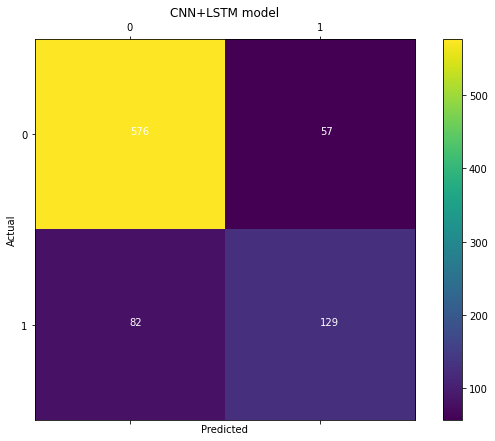

val_loss: 0.25133731961250305
test_loss: 0.3119417130947113
test_acc: 0.8353080749511719
precision: 0.6935483870967742
recall: 0.6113744075829384
specificity 0.909952606635071
sensitivity :  0.6113744075829384
far 0.09004739336492891
frr 0.3886255924170616


In [37]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 88, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
conv_2 = tf.keras.layers.Conv1D(filters = 45, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
# conv_3 = tf.keras.layers.Conv1D(filters = 126, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
# max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    

D_out_1 = tf.keras.layers.Dropout(0.5502528353650731)(max_2)
    
    
lstm_1 = tf.keras.layers.LSTM(223)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(13, activation = 'relu')(lstm_1)
dense_2 = tf.keras.layers.Dense(150, activation = 'relu')(dense_1)
# dense_3 = tf.keras.layers.Dense(13, activation = 'relu')(dense_2)
dense_4 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_2)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_4)

# Adam
# model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.0007916132524188809), metrics = ['accuracy'])
# SGD
model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.013168480192202132, momentum=0.4245211512655333), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])
        
# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)